In [143]:
from db_utils import query_analytics_store
import pandas as pd 
% matplotlib inline
import seaborn as sns
import numpy as np

# Tool Usage

### Count Clicks on Translate/Create from Scratch

In [144]:
query = """
SELECT
    a.event_action,
    COUNT(*) as n
FROM
    log.TranslationRecommendationUserAction_15858947 a,
    log.TranslationRecommendationUIRequests_15484897 r
WHERE 
    a.event_action in ('create_using_content_translation', 'create_from_scratch')
    AND a.event_requestToken = r.event_requestToken
GROUP BY
    a.event_action
"""
query_analytics_store(query, {})

,event_action,n
0,create_from_scratch,6
1,create_using_content_translation,88


### Count CX translations coming from tool

In [145]:
query = """
SELECT
    cx.translation_source_language as s,
    cx.translation_target_language as t,
    cx.translation_source_title as source_title,
    cx.translation_target_title as target_title,
    cx.translation_status,
    cx.translation_start_timestamp as start_timestamp,
    cx.translation_last_updated_timestamp as last_update_timestamp,
    cta.timestamp as cta_timestamp,
    u.gu_name,
    cx.translation_id

FROM
    wikishared.cx_translations cx,
    log.ContentTranslationCTA_16017678 as cta,
    centralauth.globaluser u,
    wikishared.cx_translators t
    
WHERE 
    cta.event_cta RLIKE 'article-recommender-1'
    AND cta.event_sourceLanguage = cx.translation_source_language
    AND cta.event_targetLanguage = cx.translation_target_language
    AND cta.event_sourceTitle = cx.translation_source_title
    AND cx.translation_id = t.translator_translation_id
    AND u.gu_id = t.translator_user_id
    AND u.gu_name = cta.event_token
"""

d = query_analytics_store(query, {})
d['cta_timestamp'] = d['cta_timestamp'].apply(lambda x: x[:8])
d['start_timestamp'] = d['start_timestamp'].apply(lambda x: x[:8])
d['last_update_timestamp'] = d['last_update_timestamp'].apply(lambda x: x[:8])
d = d.query("cta_timestamp <= start_timestamp")
d['month'] = d['last_update_timestamp'].apply(lambda x: int(x[:6]))
d['timestamp'] = pd.to_datetime(d['last_update_timestamp'].apply(lambda x: x[:8]))
d = d.drop_duplicates(subset = 'translation_id')

In [146]:
d

,cta_timestamp,gu_name,last_update_timestamp,s,source_title,start_timestamp,t,target_title,translation_id,translation_status,month,timestamp
0,20161120,Stinglehammer,20161120,fr,Gaynor le damné,20161120,en,Gaynor the damned,233671,draft,201611,2016-11-20
1,20161123,Ewulczyn (WMF),20161123,en,Wirehaired Vizsla,20161123,simple,Wirehaired Vizsla,234952,draft,201611,2016-11-23


### Count articles created from scratch from tool

For this to actually work, we need to log username of the user clicking create from scratch, since the article could have been created by someone else. Right now, I am just enforcing that the timestamps of the create from scratch and on-wiki creation events are close (WIP).

In [167]:

query = """
SELECT 
    *
FROM
    log.PageCreation_7481635 c,
    log.TranslationRecommendationUserAction_15419947 a,
    log.TranslationRecommendationUIRequests_15484897 r
WHERE 
    CONCAT(r.event_targetLanguage, '.wikipedia.org') = c.webHost
    AND a.event_requestToken = r.event_requestToken
    AND a.event_targetTitle = c.event_title 
    AND a.event_action = 'create_from_scratch' 
    AND c.event_namespace = 0
LIMIT 10
"""
#query_analytics_store(query , {})

""


# Suggestions API

### Count CX translations coming suggestions feature

In [163]:
query = """
SELECT
    cx.translation_source_language as s,
    cx.translation_target_language as t,
    cx.translation_source_title as source_title,
    cx.translation_target_title as target_title,
    cx.translation_status,
    cx.translation_start_timestamp as start_timestamp,
    cx.translation_last_updated_timestamp as last_update_timestamp,
    cta.timestamp as cta_timestamp,
    u.gu_name,
    cx.translation_id
FROM
    log.ContentTranslationCTA_16017678 as cta,
    wikishared.cx_translations cx,
    wikishared.cx_translators t,
    centralauth.globaluser u
WHERE 
    cta.event_cta RLIKE 'suggestions-type'
    AND cta.event_sourceLanguage = cx.translation_source_language
    AND cta.event_targetLanguage = cx.translation_target_language
    AND cta.event_sourceTitle = cx.translation_source_title
    AND cx.translation_id = t.translator_translation_id
    AND u.gu_id = t.translator_user_id
    AND u.gu_name = cta.event_token
"""

d = query_analytics_store(query, {})
d['cta_timestamp'] = d['cta_timestamp'].apply(lambda x: x[:8])
d['start_timestamp'] = d['start_timestamp'].apply(lambda x: x[:8])
d['last_update_timestamp'] = d['last_update_timestamp'].apply(lambda x: x[:8])
d = d.query("cta_timestamp <= start_timestamp")
d['month'] = d['last_update_timestamp'].apply(lambda x: int(x[:6]))
d['timestamp'] = pd.to_datetime(d['last_update_timestamp'].apply(lambda x: x[:8]))
d = d.drop_duplicates(subset = 'translation_id')

In [164]:
d["translation_status"].value_counts()

draft        109
published     96
Name: translation_status, dtype: int64

In [165]:
d

,cta_timestamp,gu_name,last_update_timestamp,s,source_title,start_timestamp,t,target_title,translation_id,translation_status,month,timestamp
0,20161116,Albert SN,20161117,en,Carolyn Meinel,20161116,ca,Carolyn Meinel,231566,draft,201611,2016-11-17
1,20161117,Beusson,20161117,es,(231) Vindobona,20161117,ca,(231) Vindobona,231808,published,201611,2016-11-17
2,20161117,Tonifernanchez,20161117,en,Google Classroom,20161117,ca,Google Classroom,231865,draft,201611,2016-11-17
3,20161117,Margalovi,20161117,en,Jill Biden,20161117,ca,Educadora i acadèmica americana. Segona dama d...,232201,published,201611,2016-11-17
4,20161117,FingerWiki,20161117,uk,Мірзоян Арсен Романович,20161117,ru,Мирозян Арсен Романович,232208,published,201611,2016-11-17
5,20161117,Ricardocarrera2,20161117,en,Sutherland's Portrait of Winston Churchill,20161117,es,Retrato de Winston Chruchill de Graham Sutherlnds,232223,draft,201611,2016-11-17
6,20161117,Sara Ochoa,20161117,simple,Harihara,20161117,es,Harihara,232240,draft,201611,2016-11-17
7,20161117,Akram x,20161117,en,"St Helen's Church, Ashby-de-la-Zouch",20161117,ar,"St Helen's Church, Ashby-de-la-Zouch",232241,draft,201611,2016-11-17
8,20161117,Izitpajn,20161117,hr,Friedrich von Hayek,20161117,sh,Friedrich von Hayek,232244,published,201611,2016-11-17
10,20161117,Delil87,20161118,en,Disappearance of Lisa Irwin,20161117,es,La desaparición de Lisa Irwin,232253,published,201611,2016-11-18


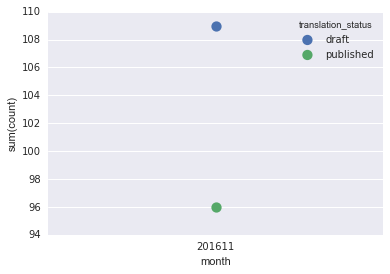

In [166]:
d['count'] = 1
sns.pointplot(x = 'month', y = 'count', data = d, estimator = np.sum, hue = 'translation_status')